In [1]:
library(Seurat)
library(Matrix)
library(dplyr)
library(tibble)
library(ggplot2)

inputdir <- "./load_files/"
outputdir <- "./report/"

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## The following dataset has a "DS" assay containing subset data acorss ages
rgc <- readRDS(file = paste0("./load_files/", "RGC_seu_for_DEG_analysis.rds"))


In [3]:
avgFile <- "./load_files/Enrich.FRealy.oRG.markers.avg.Rdata"

if (!file.exists(avgFile)){
    ## Subset to NESC-vRG early (Just compare FC vs OC)
    early <- subset(rgc, cluster2 %in% c("NEP RSPO3", "vRG HMGA2 CCND1") & region %in% c("FR", "OX"))
    Idents(early) <- "region"
    avg_early <- AverageExpression(early, assay = "RNA")$RNA


    ## Subset to OCC regions (Compare oRG versus the rest of cells)
    occ <- subset(rgc, lobe %in% c("OcC"))
    occ$avgcls <- ifelse(occ$cluster2 %in% c("oRG HOPX APOE", "oRG HOPX TNC"), "oRG", "others")
    Idents(occ) <- "avgcls"
    avg_occ <- AverageExpression(occ, assay = "RNA")$RNA

    save(avg_early, avg_occ, file = paste0(inputdir, "Enrich.FRealy.oRG.markers.avg.Rdata"))
}
load(file = paste0(inputdir, "Enrich.FRealy.oRG.markers.avg.Rdata"))

In [4]:
##----------------------------------------------------------------------------------------
## Use Dotplot to spot potential genes
load(file = paste0(inputdir, "Region_DEGs_res_v2.rds")) ## vrg_deg, org_deg
genes <- unlist(vrg_deg) %>% union(., unlist(org_deg)) %>% unique()
psval <- 0.1

pdata <- data.frame(gene = genes, 
            FC_vs_OX = (avg_early[genes, "FR"] + psval)/(avg_early[genes, "OX"] + psval), 
            oRG_vs_bg = (avg_occ[genes, "oRG"] + psval)/(avg_occ[genes, "others"] + psval), 
            stringsAsFactors = FALSE) %>%
            mutate(FC_vs_OX = MinMax(log(FC_vs_OX), min = -1, max = 2.5)) %>%
            mutate(oRG_vs_bg = MinMax(log(oRG_vs_bg), min = -1, max = 2.5)) %>%
            mutate(label = ifelse(FC_vs_OX >= 0.85 & oRG_vs_bg >= 0.85, gene, NA)) %>%
            mutate(color = ifelse(is.na(label), "lightgrey", "red")) %>%
            mutate(size = ifelse(is.na(label), 1.5, 3.5))
p1 <- ggplot(pdata, aes_string(x = "oRG_vs_bg", y = "FC_vs_OX", label = "label", color = "color", size = "size")) + 
            ggrastr::rasterise(geom_point(shape = 16, alpha = 0.8), dpi = 300) + 
            ggrepel::geom_text_repel(size = 4, color = "black", seed = 42) +
            theme_bw() + 
            scale_size_identity() + 
            scale_color_identity() +
            labs(y = "logFC (FC / OcC RGearly)", x = "logFC (oRG / others in OCC)") +
            coord_fixed() + 
            theme(panel.grid.minor = element_blank(),
                panel.grid.major = element_blank(),
                axis.title = element_text(size = rel(0.9)), 
                axis.text = element_text(size = rel(1)), 
                axis.line = element_line(size = 0.2), 
                axis.ticks = element_line(size = 0.2), 
                legend.position = "right")

Warning message:
“Removed 540 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 559 rows containing missing values (geom_text_repel).”


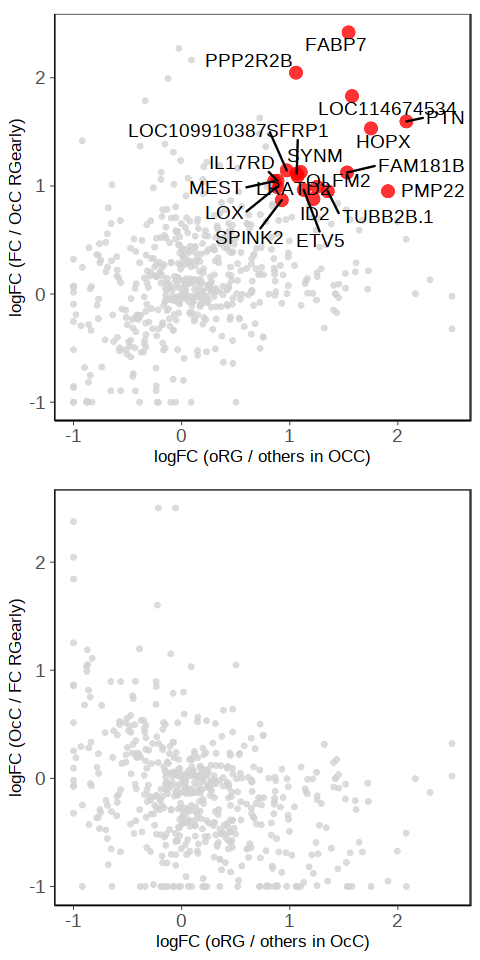

In [5]:
## See if the occipital-enriched genes show any overlap with oRG genes
genes <- unlist(vrg_deg) %>% union(., unlist(org_deg)) %>% unique()
psval <- 0.1

pdata <- data.frame(gene = genes, 
            FC_vs_OX = (avg_early[genes, "OX"] + psval)/(avg_early[genes, "FR"] + psval), 
            oRG_vs_bg = (avg_occ[genes, "oRG"] + psval)/(avg_occ[genes, "others"] + psval), 
            stringsAsFactors = FALSE) %>%
            mutate(FC_vs_OX = MinMax(log(FC_vs_OX), min = -1, max = 2.5)) %>%
            mutate(oRG_vs_bg = MinMax(log(oRG_vs_bg), min = -1, max = 2.5)) %>%
            mutate(label = ifelse(FC_vs_OX >= 0.85 & oRG_vs_bg >= 0.85, gene, NA)) %>%
            mutate(color = ifelse(is.na(label), "lightgrey", "red")) %>%
            mutate(size = ifelse(is.na(label), 1.5, 3.5))
p2 <- ggplot(pdata, aes_string(x = "oRG_vs_bg", y = "FC_vs_OX", label = "label", color = "color", size = "size")) + 
            ggrastr::rasterise(geom_point(shape = 16, alpha = 0.8), dpi = 300) + 
            ggrepel::geom_text_repel(size = 4, color = "black", seed = 42) +
            theme_bw() + 
            scale_size_identity() + 
            scale_color_identity() +
            labs(y = "logFC (OcC / FC RGearly)", x = "logFC (oRG / others in OcC)") +
            coord_fixed() + 
            theme(panel.grid.minor = element_blank(),
                panel.grid.major = element_blank(),
                axis.title = element_text(size = rel(0.9)), 
                axis.text = element_text(size = rel(1)), 
                axis.line = element_line(size = 0.2), 
                axis.ticks = element_line(size = 0.2), 
                legend.position = "right") 
pdot <- cowplot::plot_grid(p1, p2, nrow = 2, ncol = 1)
options(repr.plot.width=4, repr.plot.height=8)
pdot

In [6]:
pdf(paste0(outputdir, "Enrich_OCearly_oRG_markers_dotplot.pdf"), width = 6, height = 6, useDingbats = FALSE)
print(pdot)
dev.off()

png 
  2

In [7]:
##----------------------------------------------------------------------------------------
## Check if oRG markers can distingui early FC and OC RGC cells
occ <- subset(rgc, lobe %in% c("OcC"))
occ$avgcls <- ifelse(occ$cluster2 %in% c("oRG HOPX APOE", "oRG HOPX TNC"), "oRG", "others")
Idents(occ) <- "avgcls"
occ_org_res <- FindMarkers(occ, ident.1 = "oRG", ident.2 = "others", 
                           min.pct = 0.1, max.cells.per.ident = 1000, logfc.threshold = 0.1)
occ_org_mars <- occ_org_res %>%
                top_n(., 100, wt = avg_logFC) %>%
                rownames()
summary(occ_org_mars)

   Length     Class      Mode 
      100 character character 

In [8]:
## AUCell enrichment of the occ oRG markers
library(AUCell)
GetModuleScore <- function (assay.data, features, nbin = 24, 
                            ctrl = 100, k = FALSE, seed = 42, 
                            method = c("seurat","aucell")[2], 
                            input_dir = new_inputdir, file_name, 
                            output_dir = outputdir, rethreshold_list = NULL, cellbin.size = 8000) {
     if (is.null(x = features)) {
        stop("Missing input feature list")
    }
    features <- lapply(X = features, FUN = function(x) {
        return(intersect(x = x, y = rownames(x = assay.data)))
    })
    cluster.length <- length(x = features) #number of feature list

    if (method == "aucell"){
        library(AUCell)
        if (!file.exists(paste0(input_dir, file_name, "_modulescore_auc_res.rds"))){
            #Split the cells to bins[Sometimes, the matrix is too large for rankings]
            if (ncol(assay.data) < cellbin.size){
                cellbin.size <- ceiling(ncol(assay.data)/2)
            }
            bin.ind <- ceiling(c(1:ncol(assay.data))/cellbin.size)
            max.bin <- max(bin.ind)

            auc_list <- lapply(1:max.bin, function(tembin) {
                tem_matrix <- assay.data[, bin.ind == tembin]
                tem_rankings <- AUCell_buildRankings(tem_matrix, nCores=1, plotStats=FALSE) 
                tem_auc <- AUCell_calcAUC(features, tem_rankings)#, aucMaxRank = 500)
                tem_aucmatrix <- t(as.matrix(getAUC(tem_auc)))
                rm(tem_matrix, tem_rankings)
                return(tem_aucmatrix)
                })

            hauc_matrix <- do.call(rbind, auc_list)

            if (length(auc_list) == 1){ #When the input is not a named list, the colnames will be "Geneset"
                colnames(hauc_matrix) <- names(features)
            }
            saveRDS(hauc_matrix, file = paste0(input_dir, file_name, "_modulescore_auc_res.rds"))
        } else {
            hauc_matrix <- readRDS(paste0(input_dir, file_name, "_modulescore_auc_res.rds"))
        }
        
        set.seed(seed)
        pdf(paste0(output_dir, file_name, "_modulescore_auc_auto_assignment.pdf"), paper="letter")
        par(mfrow=c(2,2)); cells_assignment <- AUCell_exploreThresholds(t(hauc_matrix), plotHist=TRUE, assign=TRUE) 
        dev.off()

        #Generate assignment matrix (rownames as cells)
        default_assign <- hauc_matrix * 0 #build an empty one
        for (gset in colnames(hauc_matrix)){
            default_assign[cells_assignment[[gset]]$assignment, gset] <- 1
        }

        outdata <- list(auc = hauc_matrix, auto = default_assign, custom = default_assign)

        if (!is.null(rethreshold_list)){
            pdf(paste0(output_dir, file_name, "_modulescore_auc_custom_assignment.pdf"), paper="letter")
            for (j in names(rethreshold_list)){
                AUCell_plotHist(t(hauc_matrix)[j,,drop = FALSE], aucThr=rethreshold_list[[j]])
                abline(v=rethreshold_list[[j]])
                cells_assignment[[j]]$assignment <- rownames(hauc_matrix)[hauc_matrix[, j] >= rethreshold_list[[j]]]
            }
            dev.off()

            ##default_assign <- hauc_matrix * 0 #build an empty one
            for (gset in colnames(hauc_matrix)){
                default_assign[, gset] <- 0
                default_assign[cells_assignment[[gset]]$assignment, gset] <- 1
            }
            outdata$custom <- default_assign
        }
        return(outdata)
    }
}

sdata <- GetModuleScore(assay.data = rgc$RNA@data, 
                        features = list(oRGmars = occ_org_mars), 
                        method = "aucell", input_dir = inputdir, 
                        file_name = paste0("Enrich_FRearly_oRG_markers_AUC"), 
                        cellbin.size = 8000) 


Attaching package: ‘AUCell’


The following object is masked from ‘package:base’:

    cbind




`summarise()` has grouped output by 'cluster'. You can override using the `.groups` argument.



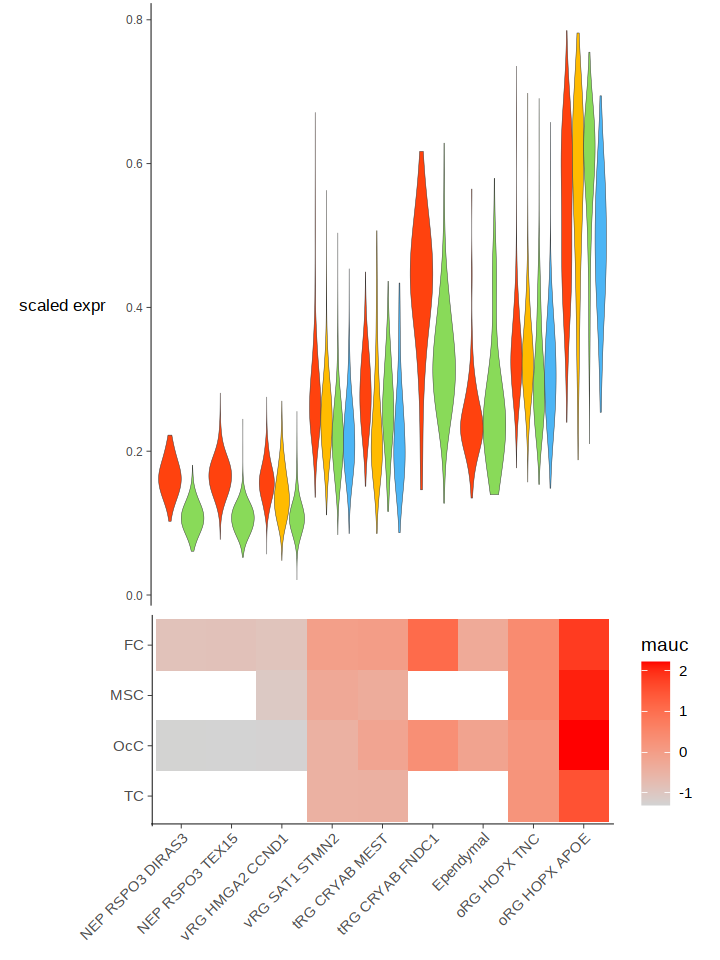

In [9]:
cls_ord <- c("NEP RSPO3 DIRAS3", "NEP RSPO3 TEX15", "vRG HMGA2 CCND1", 
             "vRG SAT1 STMN2", "tRG CRYAB MEST", "tRG CRYAB FNDC1", "Ependymal", "oRG HOPX TNC", "oRG HOPX APOE")
pdata <- sdata$auc %>%
            as.matrix() %>%
            cbind(., rgc@meta.data[, c("cluster", "lobe")]) %>%
            filter(cluster != "RGC FABP7 PMP22") %>%
            mutate(cluster = factor(cluster, levels = cls_ord)) %>%
            mutate(lobe = factor(as.character(lobe), levels = c("FC", "MSC", "OcC", "TC")))

reg_cols <- c("#FF420E", "#FFBB00", "#4CB5F5", "#89DA59", "#878787", "#B037C4") %>% 
            setNames(., c("FC", "MSC", "TC", "OcC", "Insula", "GE"))
p1 <- ggplot(pdata, aes_string(x = "cluster", y = "oRGmars", fill = "lobe")) + 
            geom_violin(scale = "width", size = 0.1, adjust = 2,trim =TRUE) + 
            theme_classic() + 
            scale_fill_manual(values = reg_cols) +
            labs(y = "scaled expr") +
            theme(axis.title.x = element_blank(), 
                  axis.title.y = element_text(size = rel(0.9), angle = 0, hjust = 1, vjust = 0.5), 
                  axis.text.x = element_text(size = rel(0.9), angle = 45, hjust = 1, vjust = 1), 
                  axis.line.x = element_line(size = 0.2), axis.ticks.x = element_line(size = 0.2), 
                  axis.text.y = element_text(size = rel(0.8)), axis.line.y = element_line(size = 0.2), 
                  axis.ticks.y = element_line(size = 0.2), legend.position = "none", 
                  plot.margin = unit(c(-0.05, 0, -0.05, 0), "in")) +
            theme(axis.text.x = element_blank())


## Get the mean value
pdata2 <- sdata$auc %>%
            as.matrix() %>% ##MinMax(., min = -2.5, max = 2.5) %>%
            cbind(., rgc@meta.data[, c("cluster", "lobe")]) %>%
            filter(cluster != "RGC FABP7 PMP22") %>%
            group_by(cluster, lobe) %>%
            summarize(mauc = mean(oRGmars)) %>%
            ungroup() %>%
            mutate(mauc = (mauc - mean(mauc))/sd(mauc)) %>%
            mutate(cluster = factor(cluster, levels = cls_ord)) %>%
            mutate(lobe = factor(lobe, levels = rev(c("FC", "MSC", "OcC", "TC"))))

p2 <- ggplot(pdata2, aes_string(x = "cluster", y = "lobe", fill = "mauc")) +
            geom_tile(color = NA) +
            scale_fill_gradientn(colors = c("lightgrey", "red")) + 
            coord_fixed() + 
            theme_classic() +
            RotatedAxis() +  
            theme(axis.line = element_line(size = 0.2), axis.ticks = element_line(size = 0.2), 
                axis.title = element_blank())
pauc <- patchwork::wrap_plots(p1, p2, nrow = 2, ncol = 1)
options(repr.plot.width=6, repr.plot.height=8, res = 300)
pauc

In [10]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/Tools/Anaconda3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] AUCell_1.8.0  ggplot2_3.3.0 tibble_3.0.1  dplyr_1.0.7   Matrix_1.5-3 
[6] Seurat_3.1.5 

loaded via a namespace (and not attached):
  [1] Rtsne_0.16                  ggbeeswarm_0.6.0           
  [3] colorspace_1.4-1            ellipsis_0.3.2             
 